In [1]:
import tensorflow as tf
import data_utils
import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
Model_Folder = "TEST_MODEL_0602"

In [3]:
model = tf.keras.models.load_model(Model_Folder+'/model.valid_00.best.h5')

In [4]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 216, 128)]   0                                            
__________________________________________________________________________________________________
gaussian_dropout_5 (GaussianDro (None, 216, 128)     0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 128)     0           gaussian_dropout_5[0][0]         
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 216, 128)     0           dropout_15[0][0]                 
_______________________________________________________________________________________

In [5]:
attention_output = model.layers[-6].output
logit_output = model.layers[-5].output
attented_logits = model.layers[-4].output
outputs = [attention_output, logit_output, attented_logits]
wierd_model = tf.keras.Model(inputs=model.inputs, outputs=outputs)

In [6]:
ds, meta = data_utils.load_TFRecord()

In [7]:
it = iter(ds)

b'train/train_00388.wav' label 1 : Howling


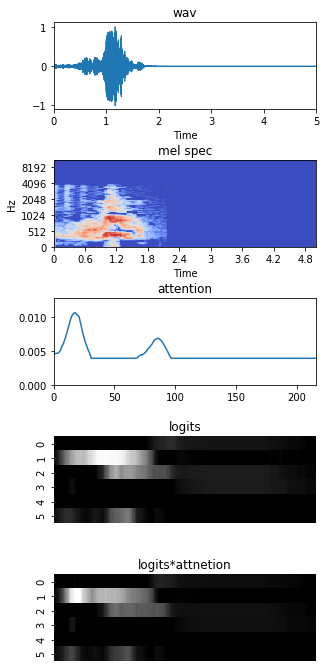

In [40]:
vmin = {
  0:0,
  None:None
}[0]
mel, label, name = next(it)
label_map = {
  idx:remark for (idx, remark) in enumerate([
    "Barking", "Howling", "Crying", "COSmoke", "GlassBreaking", "Other"
  ])
}
wav, _ = librosa.load(name.numpy())
print(name.numpy(), f"label {label.numpy()} : {label_map[label.numpy()]}")
fig, axs = plt.subplots(5,1, figsize=(5,10))
fig.tight_layout(pad=3)
librosa.display.waveplot(wav, sr=22050, ax=axs[0])

librosa.display.specshow(mel.numpy(), sr=22050, x_axis="time", y_axis="mel",ax=axs[1])

out_atten, out_logits, out_attented_logits = wierd_model.predict(mel.numpy().T[tf.newaxis])
axs[2].plot(out_atten.reshape(-1))
axs[2].set_ylim(bottom=0, top=max(0.01, np.max(out_atten)*1.2))
axs[2].set_xlim(left=0, right=216)

sns.heatmap(out_logits[0].T, ax=axs[3], cbar=False, vmin=vmin, xticklabels=False, cmap="Greys_r")
axs[3]
sns.heatmap(out_attented_logits[0].T, ax=axs[4], cbar=False, vmin=vmin, xticklabels=False, cmap="Greys_r")


for ax, title in zip(axs, ["wav", "mel spec", "attention", "logits", "logits*attnetion"]):
  ax.set_title(title)
plt.show()